In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, "/Users/alexabartlett/class/python/build/lib.macosx-10.9-x86_64-3.9")
import classy
from classy import Class
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
# from spectra import *

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12

In this notebook, we estimate the error in the matter power spectrum due to neglecting 2-loop contributions.

In [3]:
# Import velocileptors
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from velocileptors.LPT.cleft_fftw   import CLEFT
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Spline
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
import pyfftw

In [4]:
# Term proportional to (k/knl)^4, where "Fudge Factor" FF is fit to 
def k_knl_fourth(k, FF):
    return (k/FF)**4

# Function to run CLASS and determine best-fit FF
def getTheoryError(z, sigma_8, kfid, pfid, FF_guess):
    """Returns fractional error arising from ignoring 2+ loop PT"""

    params = {
    'output': 'mPk',
    'P_k_max_h/Mpc': 100.,
    'z_pk': '0.0,%.3f'%(z),
    'sigma8': sigma_8,
    'n_s': 0.96,
    'h':0.68,
    'Omega_cdm':0.25337,
    'Omega_b':0.04933,
    "Omega_fld": 0,
    "Omega_scf": 0}

    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()

    nonlinear = Class()
    nonlinear.set(params)
    nonlinear.set({'non_linear':'halofit'})
    nonlinear.compute()

    kk = np.logspace(-4.5,1.75,1000)

    pl = [cosmo.pk(k*cosmo.h(), z)*cosmo.h()**3 for k in kk]
    # pl = [cosmo.pk_cb_lin(k*cosmo.h(), z)*cosmo.h()**3 for k in kk]

    ept = RKECLEFT(kk,pl,N=5000)
    ept.make_ptable(D=1,kmin=5e-3,kmax=0.4,nk=250)

    kval = ept.pktable[:,0].copy()
    praw = ept.pktable[:,1].copy()
    pval = ept.pktable[:,1].copy()
    ptre = Spline(kk,pl)(kval)

    kval = ept.pktable[:,0]
    pval = ept.pktable[:,1]
    ptre = Spline(kk,pl)(kval)
    
    pval+= (pfid-Spline(kval,pval)(kfid)) / Spline(kk,kk**2*pl)(kfid) * kval**2*ptre
    print('alpha: ', (pfid-Spline(kval,praw)(kfid)) / Spline(kk,kk**2*pl)(kfid))

    ept_err = ((pval-ptre)/ptre)**2

    lpt = CLEFT(kk,pl)
    lpt.make_ptable(kmin=5e-3,kmax=0.4,nk=250)

    kval = lpt.pktable[:,0]
    pval = lpt.pktable[:,1]
    ptre = Spline(kk,pl)(kval)
    pval+= (pfid-Spline(kval,pval)(kfid)) / Spline(kk,kk**2*pl)(kfid) * kval**2*ptre
    lpt_err = ((pval-ptre)/ptre)**2

    FF = curve_fit(k_knl_fourth, kval, lpt_err, p0=FF_guess)[0]
    print('FF: ', FF)
    # FF = FF_guess

    return kval, (kval/FF)**4, ept_err, lpt_err


In [5]:
ks_sig8p7, estimate_sig8p7, ept_sig8p7, lpt_sig8p7 = getTheoryError(0, 0.7, 0.3, 1300, 0.3)
ks_sig8p76, estimate_sig8p76, ept_sig8p76, lpt_sig8p76 = getTheoryError(0, 0.76, 0.25, 2000, 0.3)
ks_sig8p81, estimate_sig8p81, ept_sig8p81, lpt_sig8p81 = getTheoryError(0, 0.8110, 0.2, 3200, 0.3)
ks_sig8p86, estimate_sig8p86, ept_sig8p86, lpt_sig8p86 = getTheoryError(0, 0.86, 0.15, 5000, 0.3)

/Users/alexabartlett/opt/anaconda3/lib/python3.9/site-packages/velocileptors/Utils/loginterp.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  lneff = derivative(yint, x[l], dx = x[l]*ldx, order = lorder)*x[l]/y[l]
/Users/alexabartlett/opt/anaconda3/lib/python3.9/site-packages/velocileptors/Utils/loginterp.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  rneff = derivative(yint, x[r], dx = x[r]*rdx, order = rorder)*x[r]/y[r]


alpha:  4.172711707759358
FF:  [0.30313019]
alpha:  5.25496455870523
FF:  [0.28086661]
alpha:  8.77166524500647
FF:  [0.24748916]
alpha:  12.052069333182066
FF:  [0.22467275]


In [6]:
ks_z0, estimate_z0, ept_z0, lpt_z0 = getTheoryError(0, 0.7786749510026615, 0.2, 3000, 0.3)
ks_zp5, estimate_zp5, ept_zp5, lpt_zp5 = getTheoryError(0.5, 0.7786749510026615, 0.25, 1300, 0.35)
ks_z1, estimate_z1, ept_z1, lpt_z1 = getTheoryError(1, 0.7786749510026615, 0.3, 600, 0.43)
ks_z1p5, estimate_z1p5, ept_z1p5, lpt_z1p5 = getTheoryError(1.5, 0.7786749510026615, 0.35, 300, 0.47)

alpha:  10.078894588914624
FF:  [0.2425296]
alpha:  9.324482818830454
FF:  [0.26715836]
alpha:  7.972608155360115
FF:  [0.30021069]
alpha:  6.277962011964637
FF:  [0.34508261]


In [7]:
# Extracting colors from colormaps for plot
cmap = plt.colormaps['viridis']
cmap2 = plt.colormaps['plasma']
num_colors = 5
c_posns = np.linspace(0, 1, num_colors)
c = cmap(c_posns)
c2 = cmap2(c_posns)

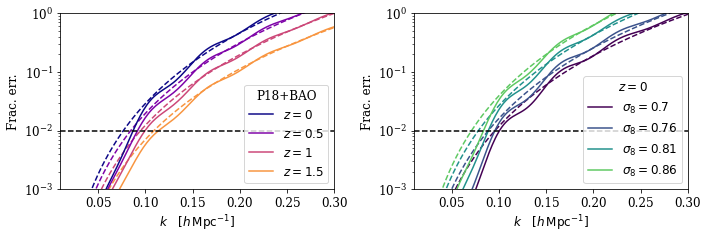

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,3.5))
# c2 = ['blue', 'darkviolet', 'hotpink', 'red']

axs[0].plot(ks_z0, estimate_z0, ls='--', color=c2[0])
axs[0].plot(ks_z0, estimate_zp5, ls='--', color=c2[1])
axs[0].plot(ks_z1, estimate_z1, ls='--', color=c2[2])
axs[0].plot(ks_z1p5, estimate_z1p5, ls='--', color=c2[3])

axs[0].plot(ks_z0, lpt_z0, label=r'$z=0$', color=c2[0])
axs[0].plot(ks_zp5, lpt_zp5, label=r'$z=0.5$', color=c2[1])
axs[0].plot(ks_z1, lpt_z1, label=r'$z=1$', color=c2[2])
axs[0].plot(ks_z1p5, lpt_z1p5, label=r'$z=1.5$', color=c2[3])

axs[0].set_yscale('log')
axs[0].set_ylim(1e-3,1)
axs[0].set_xlim(0.01,0.3)
axs[0].set_xlabel(r'$k\quad [h\,\mathrm{Mpc}^{-1}]$', fontsize=12)
axs[0].set_ylabel(r'Frac. err.', fontsize=12)
axs[0].legend(title=r'P18+BAO', title_fontsize=12, fontsize=12)

axs[0].axhline(0.01, color='k', ls='--')

# c = ['darkviolet', 'mediumslateblue', 'deepskyblue', 'cyan']
# c = ['navy', 'dodgerblue', 'mediumspringgreen', 'yellowgreen']

axs[1].plot(ks_sig8p7, estimate_sig8p7, ls='--', color=c[0])
axs[1].plot(ks_sig8p76, estimate_sig8p76, ls='--', color=c[1])
axs[1].plot(ks_sig8p81, estimate_sig8p81, ls='--', color=c[2])
axs[1].plot(ks_sig8p86, estimate_sig8p86, ls='--', color=c[3])

axs[1].plot(ks_sig8p7, lpt_sig8p7, label=r'$\sigma_8=0.7$', color=c[0])
axs[1].plot(ks_sig8p76, lpt_sig8p76, label=r'$\sigma_8=0.76$', color=c[1])
axs[1].plot(ks_sig8p81, lpt_sig8p81, label=r'$\sigma_8=0.81$', color=c[2])
axs[1].plot(ks_sig8p86, lpt_sig8p86, label=r'$\sigma_8=0.86$', color=c[3])

axs[1].axhline(0.01, color='k', ls='--')

axs[1].set_yscale('log')
axs[1].set_ylim(1e-3,1)
axs[1].set_xlim(0.01,0.3)
axs[1].set_xlabel(r'$k\quad [h\,\mathrm{Mpc}^{-1}]$', fontsize=12)
axs[1].set_ylabel(r'Frac. err.', fontsize=12)
axs[1].legend(title=r'$z=0$', title_fontsize=12, fontsize=12)

fig.tight_layout()
plt.savefig('figures/theory_errs.pdf')